# Write forward and backward projectors for the phantom

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "0"

import sys
import time

import numpy as np
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
%matplotlib ipympl

import ImageD11.sinograms.dataset
import ImageD11.sinograms.tensor_map
import ImageD11.sinograms.geometry

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

start_time = time.time()

/tmp/ipykernel_2030518/1834362176.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# ImageD11.sinograms.geometry stuff

@jax.jit
def _dty_values_grain_in_beam_sincos(sx, sy, y0, sinomega, cosomega):
    dty = y0 - sx * sinomega - sy * cosomega
    return dty

@jax.jit
def _dty_values_grain_in_beam(sx, sy, y0, omega):
    """Calls dty_values_grain_in_beam_sincos after converting omega (degrees) into sinomega, cosomega"""
    omega_rad = jnp.radians(omega)
    sinomega = jnp.sin(omega_rad)
    cosomega = jnp.cos(omega_rad)
    return _dty_values_grain_in_beam_sincos(sx, sy, y0, sinomega, cosomega)

@jax.jit
def _step_to_sample(si, sj, ystep):
    """Converts step space (si, sj) to sample position (sx, sy)"""
    sx = si * ystep
    sy = -sj * ystep
    return sx, sy

@jax.jit
def _recon_to_step(ri, rj, recon_shape):
    """Converts reconstruction space (ri, rj) to step space (si, sj)"""
    si = ri - (recon_shape[0] // 2)
    sj = rj - (recon_shape[1] // 2)
    return si, sj

@jax.jit
def _recon_to_sample(ri, rj, recon_shape, ystep):
    """Converts reconstruction space (ri, rj) to sample space (sx, sy)"""
    si, sj = _recon_to_step(ri, rj, recon_shape)
    sx, sy = _step_to_sample(si, sj, ystep)
    return sx, sy

@jax.jit
def _recon_omega_to_dty(ri, rj, omega, y0, recon_shape, ystep):
    """
    Convert recon space (ri, rj) to step space (si, sj)
    Then get corresponding dty values which puts (si, sj) into the beam given omega
    """
    sx, sy = _recon_to_sample(ri, rj, recon_shape, ystep)
    dty = _dty_values_grain_in_beam(sx, sy, y0, omega)
    return dty

In [3]:
tmap = ImageD11.sinograms.tensor_map.TensorMap.from_h5('phantom.h5')
ucell = tmap.phases[0]
ucell

Cr | [ 2.885  2.885  2.885 90.    90.    90.   ] | 229

In [4]:
doplot = True

[1. 2. 2.]


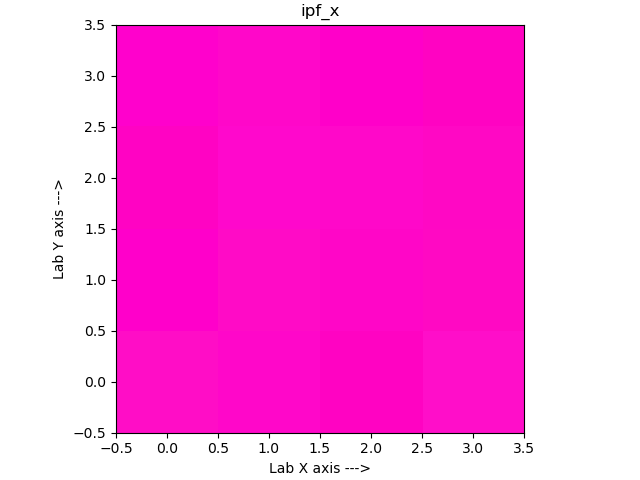

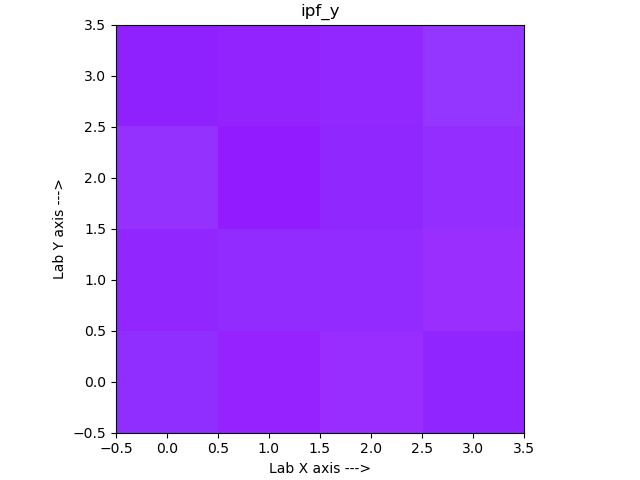

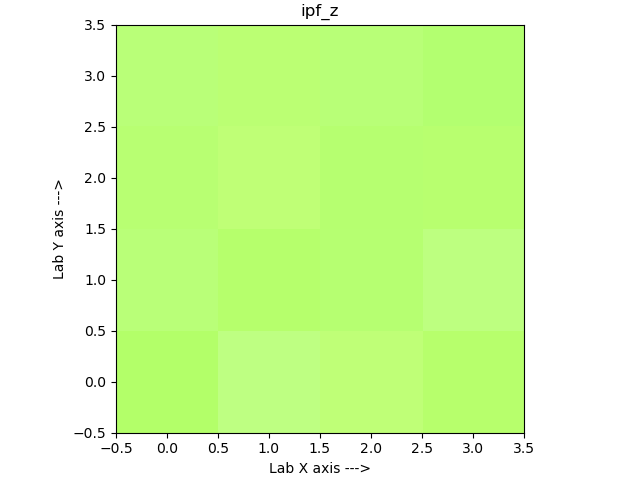

In [5]:
print(tmap.steps)  # steps in microns
if doplot:
    tmap.plot('ipf_x')
    tmap.plot('ipf_y')
    tmap.plot('ipf_z')

In [6]:
asc = ImageD11.unitcell.Phases.from_json('pars.json')
pars = asc.geometry_pars_obj
npx = 2_048
pars.set('distance', 100e3)  # 100 mm
pars.set('wavelength', 0.2883)  # 43 kev
pars.set('y_center', npx//2)
pars.set('z_center', npx//2)
pars.set('chi', 0.0)
pars.set('wedge', 0.0)
pars.set('y_size', 75.0)
pars.set('z_size', 75.0)
pars.set('tilt_x', 0.0)
pars.set('tilt_y', 0.0)
pars.set('tilt_z', 0.0)
pars.get_parameters()
asc.save()

In [7]:
sys.path.insert(0, '../')
import transform_map_batch as mytrans

In [8]:
import importlib
importlib.reload(mytrans)

<module 'transform_map_batch' from '/home/esrf/james1997a/Code/Anri/anri/sandbox/forward_backward/../transform_map_batch.py'>

## Define our detector transforms

In [9]:
det_trans, beam_cen_shift, x_distance_shift = mytrans.detector_transforms(pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                                                          pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                                                          pars.get('tilt_x'),
                                                                          pars.get('distance'),
                                                                          pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))
det_trans, beam_cen_shift, x_distance_shift

(Array([[  0.,   0.,   1.],
        [  0., -75.,   0.],
        [-75.,   0.,   0.]], dtype=float64),
 Array([-1024, -1024,     0], dtype=int64),
 Array([100000.,      0.,      0.], dtype=float64))

In [10]:
UB_recon_space = tmap.map_order_to_recon_order(tmap.UB, z_layer=0)
UB_recon_space.shape

(4, 4, 3, 3)

In [11]:
nz, ny, nx = tmap.shape
ystep = tmap.steps[1]
ny, ystep

(4, 2.0)

In [12]:
# convenience
wavelength = pars.get('wavelength')
chi = pars.get('chi')
wedge = pars.get('wedge')
y0 = 0
recon_shape = UB_recon_space.shape[:2]

In [13]:
ri, rj = np.mgrid[:ny, :ny]
# ri, rj

In [14]:
UB_flat = jnp.array(UB_recon_space.reshape(-1, 3, 3))
ri_flat = jnp.array(ri.reshape(-1,))
rj_flat = jnp.array(rj.reshape(-1,))

In [15]:
# it's helpful to have a grid of (sx, sy) for the backward projector
# also makes the lookups for position easier
# cheap and easy to pre-compute, even for big maps

In [16]:
sx_flat, sy_flat = _recon_to_sample(ri_flat, rj_flat, recon_shape, ystep)
sx_grid = sx_flat.reshape((ny, ny))
sy_grid = sy_flat.reshape((ny, ny))

In [17]:
UB_flat.shape, ri_flat.shape, rj_flat.shape

((16, 3, 3), (16,), (16,))

In [18]:
import Dans_Diffraction as dif

crystal = dif.Crystal('ICSD_213353_scaled.cif')
crystal.Scatter.setup_scatter(scattering_type='xray',
                              wavelength_a=asc.geometry_pars_obj.get('wavelength'), 
                              powder_units='twotheta',
                              min_twotheta=0.1,
                              max_twotheta=30,
                              min_theta=-np.inf,
                              max_theta=np.inf
                             )

Scatter(ICSD_213353_scaled with 1 atomic positions, 96 symmetries)
       Type: xray
     Energy: 43.005351692249974 keV
 Wavelength: 0.2883 A
 ---Settings---
      Powder units: twotheta
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -inf
         max theta: inf
      min twotheta: 0.1
      max twotheta: 30
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Neutron Settings---
 Sears (ITC) scattering lengths: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True



In [19]:
ucell.makerings(3.0)
hkls_all = jnp.array(np.concatenate(list(ucell.ringhkls.values())).astype(int))

In [20]:
hkls_all

Array([[-1, -1,  0],
       [ 0, -1, -1],
       [ 0, -1,  1],
       ...,
       [ 4,  7,  3],
       [ 3,  4,  7],
       [ 3,  7,  4]], dtype=int64)

In [21]:
intensities = crystal.Scatter.intensity(hkls_all)

In [22]:
# to forward project, supply an index to the flat list of voxels and an HKL
# we compute the gve for that HKL, then forward project into the detector
# we return sc, fc, omega, intensity

In [23]:
k_in_unit = jnp.array([1., 0., 0])  # needs normalising by wavelength
k_in_norm = mytrans._scale_norm_k(k_in_unit, pars.get('wavelength'))

In [24]:
# it's nice to have a core function which we call with (UBI)

In [25]:
# forward project a UB and position in the sample frame
# gives us ideal positions, infinitely sharp
def _fwd_ub(UB, hkl, sx, sy):
    origin_sample = jnp.array([sx, sy, 0])
    # get gve here for this hkl
    gve = UB @ hkl

    # work out q-vectors in lab frame and omega angles to diffract
    [q_lab1, q_lab2], [omega1, omega2], valid = mytrans._q_sample_to_q_lab(gve, k_in_norm, wedge, chi)

    # work out corresponding dty values given (sx, sy, omega)
    dty1 = _dty_values_grain_in_beam(sx, sy, y0, omega1)
    dty2 = _dty_values_grain_in_beam(sx, sy, y0, omega2)

    # now we can work out diffraction origin in the lab frame by rotating origin_sample by omega
    origin_lab_1 = mytrans._sample_to_lab(origin_sample, omega1, wedge, chi)
    origin_lab_2 = mytrans._sample_to_lab(origin_sample, omega2, wedge, chi)

    # don't forget to add (dty - y0)
    dty_shift1 = jnp.array([0., dty1 - y0, 0])
    dty_shift2 = jnp.array([0., dty2 - y0, 0])
    origin_lab_1 = origin_lab_1 + dty_shift1
    origin_lab_2 = origin_lab_2 + dty_shift2

    # now forward project into the detector
    sc1, fc1 = mytrans._q_lab_to_det(q_lab1, omega1, origin_lab_1, k_in_norm, wavelength, det_trans, beam_cen_shift, x_distance_shift)
    sc2, fc2 = mytrans._q_lab_to_det(q_lab2, omega2, origin_lab_2, k_in_norm, wavelength, det_trans, beam_cen_shift, x_distance_shift)
    
    return jnp.array([sc1, sc2]), jnp.array([fc1, fc2]), jnp.array([omega1, omega2]), jnp.array([dty1, dty2])
    
@jax.jit
def get_voxel_values(voxel_idx):
    # get UB here and voxel position
    UB_voxel = UB_flat[voxel_idx]
    # get spatial position in the sample frame (rotating with diffractometer)
    sx_voxel = sx_flat[voxel_idx]
    sy_voxel = sy_flat[voxel_idx]

    return UB_voxel, sx_voxel, sy_voxel

# forward project a single voxel and peak
@jax.jit
def fwd(voxel_idx, hkl):
    # get data needed for forward simulation (UB and position in sample frame)
    UB_voxel, sx_voxel, sy_voxel = get_voxel_values(voxel_idx)

    # do the forward simulation
    sc, fc, omega, dty = _fwd_ub(UB_voxel, hkl, sx_voxel, sy_voxel)

    # this gives us perfect values
    # TODO: add some sort of peak spread function!
    
    return sc, fc, omega, dty

@jax.jit
def fwd_many_voxels_single_hkl(voxel_idxs, hkl):
    # map over voxel indices
    def kernel(voxel_idx):
        return fwd(voxel_idx, hkl)

    return jax.lax.map(kernel, voxel_idxs)

@jax.jit
def fwd_single_voxel_many_hkls(voxel_idx, hkls):
    # map over hkls
    def kernel(hkl):
        return fwd(voxel_idx, hkl)

    return jax.lax.map(kernel, hkls)

@jax.jit
def fwd_many_voxels_many_hkl(voxel_idxs, hkls):
    def kernel(voxel_idx):
        return fwd_single_voxel_many_hkls(voxel_idx, hkls)

    return jax.lax.map(kernel, voxel_idxs)

In [26]:
fwd(0, hkls_all[0])

(Array([924.44931335, 924.45747541], dtype=float64),
 Array([1185.67297515,  862.34028025], dtype=float64),
 Array([ 83.59039399, -86.89850879], dtype=float64),
 Array([ 3.5284547 , -4.21056026], dtype=float64))

In [27]:
# shape (len(voxels), len(hkls), 2)
sc, fc, omega, dty = fwd_many_voxels_many_hkl(jnp.arange(UB_flat.shape[0]), hkls_all[:])

In [28]:
omega.shape, (UB_flat.shape[0], hkls_all.shape[0], 2)

((16, 1408, 2), (16, 1408, 2))

In [29]:
# when we flatten, we go in order:
# [(voxel 0, hkl 0, fpair 0), (voxel 0, hkl 0, fpair 1), (voxel 0, hkl 1, fpair 0), (voxel 0, hkl 1, fpair 1), ..., (voxel 1, hkl 0, fpair 0) etc....]
# so:
# voxels are outer loop
# hkls are middle loop
# fpairs are inner loop

sc = sc.flatten()
fc = fc.flatten()
omega = omega.flatten()
dty = dty.flatten()

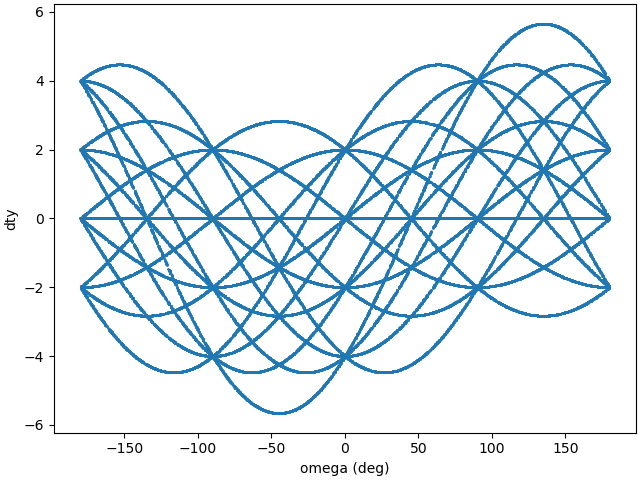

CPU times: user 373 ms, sys: 6.49 ms, total: 379 ms
Wall time: 468 ms


In [30]:
%%time
if doplot:
    fig, ax = plt.subplots(constrained_layout=True)
    ax.scatter(omega, dty, s=1)
    ax.set(xlabel='omega (deg)', ylabel='dty')
    plt.show()

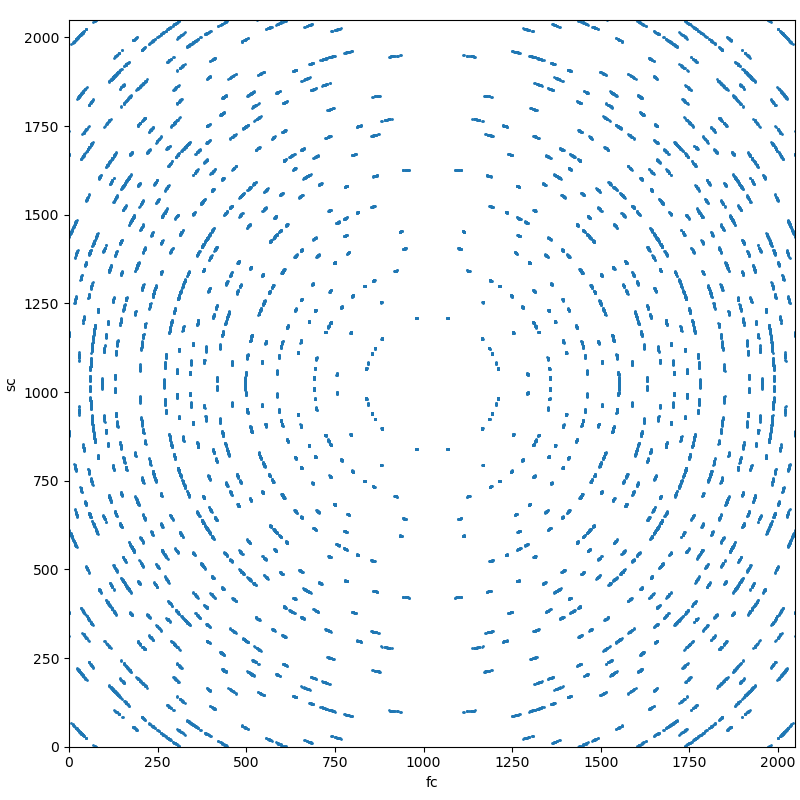

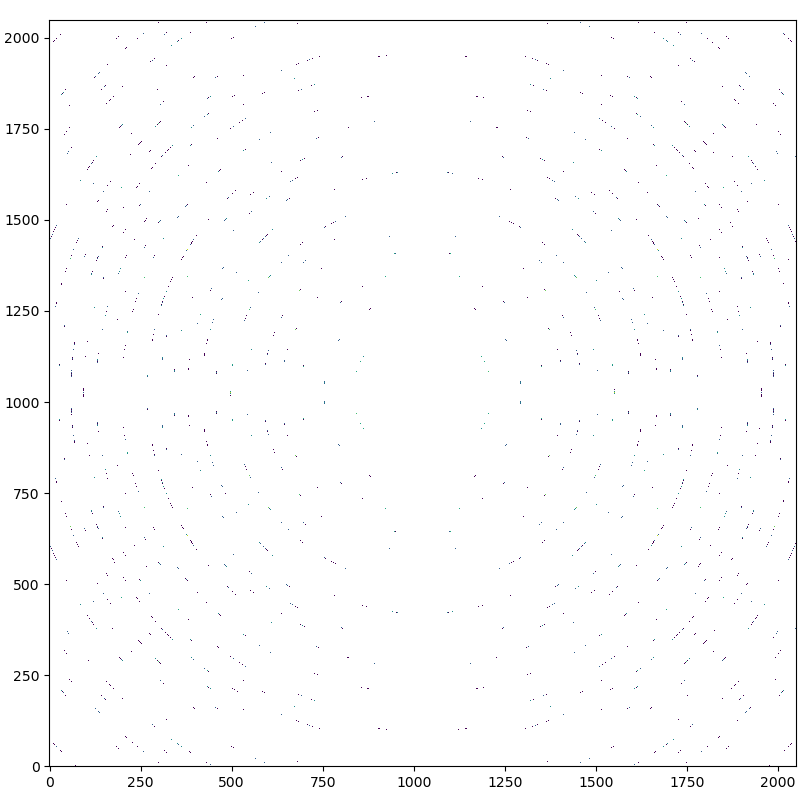

CPU times: user 485 ms, sys: 242 ms, total: 727 ms
Wall time: 722 ms


In [31]:
%%time
if doplot:
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8,8))
    ax.scatter(fc, sc, s=1)
    ax.set(xlim=(0, npx), ylim=(0, npx), aspect=1, xlabel='fc', ylabel='sc')
    plt.show()

    fig, ax = plt.subplots(constrained_layout=True, figsize=(8,8))
    img, _, _ = np.histogram2d(sc, fc, bins=(npx+1, npx+1), range=((-0.5, npx+0.5),(-0.5, npx+0.5)))
    ax.imshow(img, interpolation='nearest', origin='lower', norm='log')
    plt.show()

In [32]:
# # what's the gradient of sc, fc with UB
# jax.jacobian(_fwd_ub, argnums=0)

# ub1, sx_1, sy_1 = get_voxel_values(0)
# ub1, sx_1, sy_1

# # can we get the gradient of sc w.r.t UB for the first hkl?
# # returns sc, fc, omega, dty
# # take just sc, then just one of the friedel pairs
# # this gives us d_sc/d_UB for all components of UB
# jax.jacobian(_fwd_ub, argnums=0)(ub1, hkls_all[0], sx_1, sy_1)[0][0]*1e-4

In [33]:
# now focus on the backward projector
# given some (sc, fc, dty, omega) value, and a grain map, ray-trace into the grain map
# that's the geometric selection
# then index and filter
# that's the crystallographic selection

In [34]:
@jax.jit
def get_ray_mask(dty, omega):
    # with (dty, omega), find the pixels that are hit
    omega_rad = jnp.radians(omega)
    sinomega = jnp.sin(omega_rad)
    cosomega = jnp.cos(omega_rad)
    # from ImageD11.sinograms.geometry.point_by_point.compute_origins:
    ygrid = y0 - (sx_grid * sinomega) - (sy_grid * cosomega)
    ydist = jnp.abs(dty - ygrid)
    ray_mask = ydist <= ystep
    return ray_mask.flatten()  # same shape as flat list of voxels

In [35]:
@jax.jit
def score_single_peak(UB, gve, hkl_int):
    # score a single peak gve given a single UB and a known hkl_int
    UBI = jnp.linalg.inv(UB)
    hkl_float = UBI @ gve
    dhkl = hkl_float - hkl_int
    # Squared distance
    drlv2 = jnp.sum(dhkl**2)
    return drlv2


@jax.jit
def bwd_single_pixel_single_hkl(sc, fc, dty, omega, hkl_int):
    # geometric filter
    # get the ray_mask [shape is (n_voxels,)]
    ray_mask = get_ray_mask(dty, omega)

    # for the pixels that we hit, get the origin in the lab frame
    # go in sample frame first
    sx_to_score = jnp.where(ray_mask, sx_flat, jnp.nan)
    sy_to_score = jnp.where(ray_mask, sy_flat, jnp.nan)

    # make array in the sample frame
    origin_sample = jnp.column_stack([sx_to_score, sy_to_score, jnp.zeros_like(sx_to_score)])
    # convert to lab frame
    origin_lab = jax.vmap(mytrans._sample_to_lab, in_axes=[0,None,None,None])(origin_sample, omega, wedge, chi)

    # don't forget to add (dty - y0)
    dty_shift = jnp.array([0., dty - y0, 0])
    origin_lab = origin_lab + dty_shift
    
    # for the pixels that we hit, get the UB
    UB_to_score = jnp.where(ray_mask[..., jnp.newaxis, jnp.newaxis], UB_flat, jnp.nan)

    # now for sc, fc, omega, get the gves
    # we have one gve per voxel
    gve = jax.vmap(mytrans._det_to_q_sample, in_axes=[None, None, None, 0, None, None, None, None, None, None, None])(sc, fc, omega, origin_lab, k_in_norm, wedge, chi, wavelength, det_trans, beam_cen_shift, x_distance_shift)
    # now we score the voxel UB against the voxel gve
    
    # score the UBs that we like and return them
    scores = jax.vmap(score_single_peak, in_axes=[0, 0, None])(UB_to_score, gve, hkl_int)
    return scores

# jax.vmap version (gave OOM errors on GPU...)
# batch_over_pairs = jax.vmap(bwd_single_pixel_single_hkl, in_axes=(0,0,0,0, None))
# batch_over_hkls = jax.vmap(batch_over_pairs, in_axes=(0, 0, 0, 0, 0))
# batch_over_voxels = jax.vmap(batch_over_hkls, in_axes=(0, 0, 0, 0, None))
# bwd_project_all = jax.jit(batch_over_voxels)

# jax.lax.map version:
# we can only map over a single argument, so we have to pack-unpack
def kernel_hkl(hkl_args):
    sc_hkl, fc_hkl, dty_hkl, omega_hkl, hkl_int = hkl_args

    def pair_map_kernel(pair_args):
        # args that change per call - friedel pairs
        # these are now all single-peak values
        sc, fc, dty, omega = pair_args
        return bwd_single_pixel_single_hkl(sc, fc, dty, omega, hkl_int)
        
    # map over friedel pairs
    return jax.lax.map(pair_map_kernel, (sc_hkl, fc_hkl, dty_hkl, omega_hkl))

@jax.jit
def bwd_project_all(sc_arr, fc_arr, dty_arr, omega_arr, hkls_all):
    def voxel_map_kernel(voxel_args):
        # args that change per call - voxels
        sc_v, fc_v, dty_v, omega_v = voxel_args
        # map over hkls
        return jax.lax.map(kernel_hkl, (sc_v, fc_v, dty_v, omega_v, hkls_all))
    
    # map over voxels
    return jax.lax.map(voxel_map_kernel, (sc_arr, fc_arr, dty_arr, omega_arr))

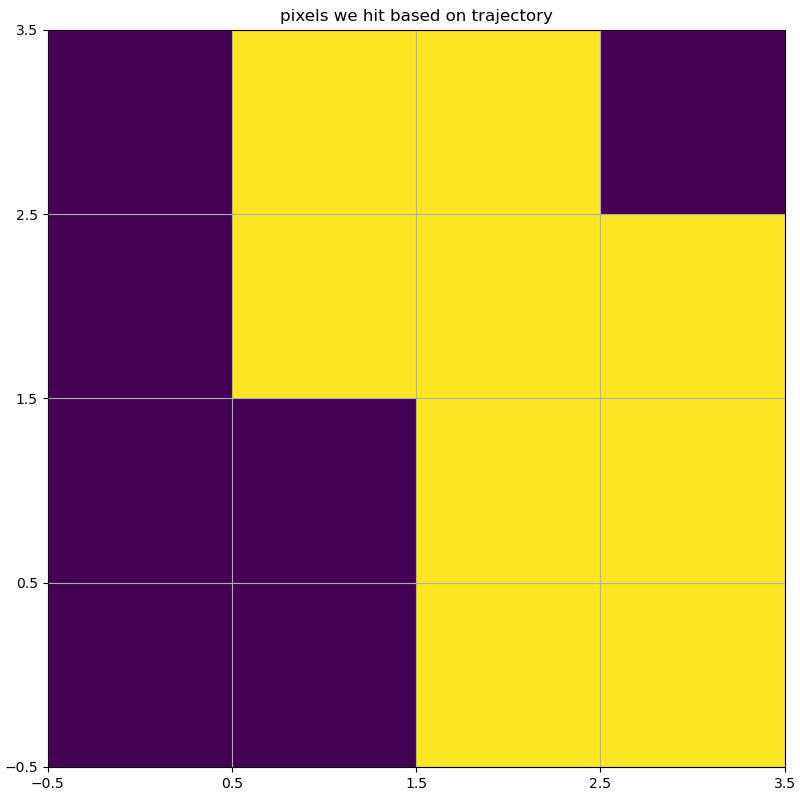

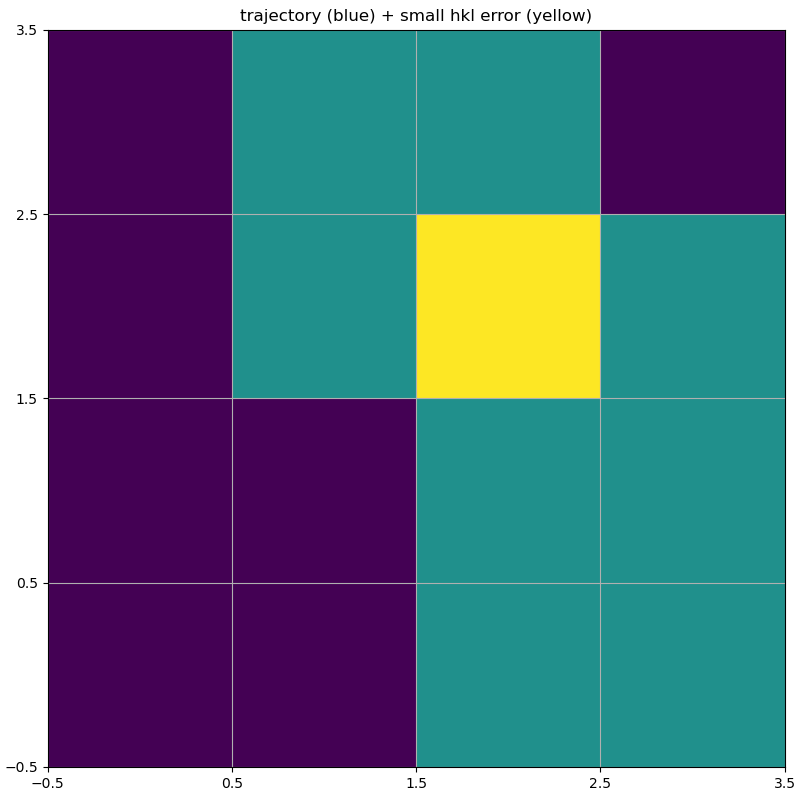

CPU times: user 517 ms, sys: 47 ms, total: 564 ms
Wall time: 659 ms


In [36]:
%%time
if doplot:
    # pick interesting idx to plot
    # middle pixel (half of total number of pixels plus half of one row)
    voxel_idx = ny * (ny + 1) // 2
    # pick some random hkl and friedel pair
    hkls_idx = 50
    fpair_idx = 1
    idx = (voxel_idx * len(hkls_all) * 2) + (hkls_idx * 2) + fpair_idx
    
    rm = get_ray_mask(dty[idx], omega[idx]).reshape((ny, ny))
    
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8,8))
    ax.imshow(rm, origin='lower')
    ax.set_xticks(np.linspace(ri_flat.min()-0.5, ri_flat.max()+0.5, ny+1))  # map voxel bin edges
    ax.set_yticks(np.linspace(ri_flat.min()-0.5, ri_flat.max()+0.5, ny+1))
    ax.grid()
    ax.set_aspect(1)
    ax.set_title('pixels we hit based on trajectory')
    
    plt.show()

    sm = (bwd_single_pixel_single_hkl(sc[idx], fc[idx], dty[idx], omega[idx], hkls_all[hkls_idx]) < 1e-12).reshape((ny, ny))
    
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8,8))
    ax.imshow(rm.astype(int) + sm.astype(int), origin='lower')
    ax.set_xticks(np.linspace(ri_flat.min()-0.5, ri_flat.max()+0.5, ny+1))
    ax.set_yticks(np.linspace(ri_flat.min()-0.5, ri_flat.max()+0.5, ny+1))
    ax.grid()
    ax.set_aspect(1)
    ax.set_title('trajectory (blue) + small hkl error (yellow)')
    plt.show()

In [37]:
%%time

# this is my fast round-robin check
# return the score matrices for each (voxel index, hkl index, 2) combination
# we get a shape of (len(voxels), len(hkls), 2, len(voxels))
# where the last axis is the scoring matrix
# the idea is that for each good value of score (e.g. < 1e-12), its last index (the scoring matrix) should match its first index

all_scores = bwd_project_all(sc.reshape((len(UB_flat), len(hkls_all), 2)),
                             fc.reshape((len(UB_flat), len(hkls_all), 2)),
                             dty.reshape((len(UB_flat), len(hkls_all), 2)),
                             omega.reshape((len(UB_flat), len(hkls_all), 2)),
                             hkls_all)

result_indices = jnp.where(all_scores < 1e-12)
assert jnp.allclose(result_indices[0], result_indices[-1])

CPU times: user 2.89 s, sys: 1.12 s, total: 4.01 s
Wall time: 4.2 s


In [38]:
# sc[0], fc[0] came from the first voxel

In [39]:
scores = bwd_single_pixel_single_hkl(sc[0], fc[0], dty[0], omega[0], hkls_all[0])
print(scores[scores < 1e-12])
print(jnp.where(scores < 1e-12))

[3.08148791e-33]
(Array([0], dtype=int64),)


In [40]:
# sc[1], fc[1] are the friedel pair of [0] so should also score well

In [41]:
scores = bwd_single_pixel_single_hkl(sc[1], fc[1], dty[1], omega[1], hkls_all[0])
print(scores[scores < 1e-12])
print(jnp.where(scores < 1e-12))

[2.19710088e-30]
(Array([0], dtype=int64),)


In [42]:
# now this is the second hkl from the same voxel:

In [43]:
scores = bwd_single_pixel_single_hkl(sc[2], fc[2], dty[2], omega[2], hkls_all[1])
print(scores[scores < 1e-12])
print(jnp.where(scores < 1e-12))

[3.13079172e-30]
(Array([0], dtype=int64),)


In [44]:
# and it's friedel pair:
scores = bwd_single_pixel_single_hkl(sc[3], fc[3], dty[3], omega[3], hkls_all[1])
print(scores[scores < 1e-12])
print(jnp.where(scores < 1e-12))

[2.16936749e-30]
(Array([0], dtype=int64),)


In [45]:
# jump to voxel 7 for example
voxel_idx = 7
hkls_idx = 50
fpair_idx = 1
pkidx = (voxel_idx * len(hkls_all) * 2) + (hkls_idx * 2) + fpair_idx
scores = bwd_single_pixel_single_hkl(sc[pkidx], fc[pkidx], dty[pkidx], omega[pkidx], hkls_all[hkls_idx])
print(scores[scores < 1e-12])
print(jnp.where(scores < 1e-12))

[1.97215226e-31]
(Array([7], dtype=int64),)


In [46]:
# get somewhere near the last peak in the block for this voxel:
voxel_idx = 7
hkls_idx = len(hkls_all)-6
fpair_idx = 1
pkidx = (voxel_idx * len(hkls_all) * 2) + (hkls_idx * 2) + fpair_idx
scores = bwd_single_pixel_single_hkl(sc[pkidx], fc[pkidx], dty[pkidx], omega[pkidx], hkls_all[hkls_idx])
print(scores[scores < 1e-12])
print(jnp.where(scores < 1e-12))

[7.09974815e-30]
(Array([7], dtype=int64),)


In [47]:
# now we move into voxel 8, peak 0:
voxel_idx = 8
hkls_idx = 0
fpair_idx = 0
pkidx = (voxel_idx * len(hkls_all) * 2) + (hkls_idx * 2) + fpair_idx
scores = bwd_single_pixel_single_hkl(sc[pkidx], fc[pkidx], dty[pkidx], omega[pkidx], hkls_all[hkls_idx])
print(scores[scores < 1e-12])
print(jnp.where(scores < 1e-12))

[1.78726299e-30]
(Array([8], dtype=int64),)


In [48]:
# little stupid round-robin check
# the above batched vmap thing is much faster
# for every detector pixel we forward project, we should match to only the voxel in the map that we originally came from
# takes around 15 seconds, turn it off for speed

do_rr = False

if do_rr:
    # print('vox hkl pk')
    pk_idx = 0
    for voxel_idx in tqdm(np.arange(UB_flat.shape[0])):
        for hkl_idx in np.arange(len(hkls_all)):
            for fpair_idx in np.arange(2):
                # print(voxel_idx, hkl_idx, pk_idx)
                sm = bwd_single_pixel_single_hkl(sc[pk_idx],
                                                fc[pk_idx],
                                                dty[pk_idx],
                                                omega[pk_idx],
                                                hkls_all[hkl_idx])
                match_idx = np.where(sm < 1e-12)[0]
                # if the peak is valid, then we care about checking it
                if not jnp.isnan(omega[pk_idx]):
                    assert match_idx.size > 0, sm
                    assert match_idx[0] == voxel_idx, (sm, match_idx)
                pk_idx += 1

In [49]:
end_time = time.time()
print(f'Took {(end_time - start_time):.0f} seconds for {len(fc)} peaks from {len(UB_flat)} voxels')

Took 10 seconds for 45056 peaks from 16 voxels
